# ML T-Generation Занятие 3: Линейная регрессия.
# Проблема переобучения. Кросс-валидация и регуляризация.

Авторы: Гаркавый Андрей (andrewgarkavyy@gmail.com), Кирилл Васильев (kirivasile@yandex.ru)

Переработал: Чайников Константин (chainikov.k.m@gmail.com)

## 0. План

1. Линейная регрессия

2. Приближение многочленом

3. Переобучение

4. Выводы

5. Разделение на тренировочную и тестовую части

6. Кросс-валидация

7. Как подбираются коэффициенты

8. Регуляризация



## 1. Линейная регрессия
**Регрессией** называется задача машинного обучения с учителем, в которой у нас есть много объектов с признаками, у которых надо научиться приближенно предсказывать значение целевой функции, которая равна какому-то **действительному числу**. 

В этом будет отличие задачи регрессии от задачи классификации - регрессия предсказывает число, а классификация - один из нескольких классов.**Текст, выделенный полужирным шрифтом**

In [11894]:
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

In [11895]:
model = LinearRegression(fit_intercept=True  )

Давайте положим в X какие-то трехмерные векторы.

In [11896]:
X = np.ones((200,3))

X[:,1]*=np.random.normal(0,1,(200,))
X[:,2]*=np.random.normal(0,1,(200,))
X

array([[ 1.00000000e+00,  1.05712648e+00,  9.30135523e-01],
       [ 1.00000000e+00, -7.28713212e-01,  3.65194842e-01],
       [ 1.00000000e+00,  1.35347021e+00,  1.16569486e-01],
       [ 1.00000000e+00,  2.64500512e-01, -9.75309274e-01],
       [ 1.00000000e+00, -3.22862798e-01,  4.89597562e-01],
       [ 1.00000000e+00,  7.88237578e-01,  3.58601572e-01],
       [ 1.00000000e+00, -5.81255567e-01, -9.47063000e-01],
       [ 1.00000000e+00,  1.67205956e+00,  7.97775660e-01],
       [ 1.00000000e+00,  8.60117029e-01,  2.34799964e+00],
       [ 1.00000000e+00, -1.84934751e-01,  2.55583910e-01],
       [ 1.00000000e+00,  4.55842636e-01, -1.50758150e+00],
       [ 1.00000000e+00,  1.82037470e+00,  9.97628432e-01],
       [ 1.00000000e+00, -3.15913994e-01, -2.28648614e-02],
       [ 1.00000000e+00, -3.24678715e-01, -1.14320471e+00],
       [ 1.00000000e+00,  1.12947364e+00,  5.23683233e-01],
       [ 1.00000000e+00,  1.65782973e+00, -9.05065938e-01],
       [ 1.00000000e+00, -1.56697259e+00

Построим $y$ по такой формуле:

$$y = 50 + 14x_1 - 7x_2  + \varepsilon$$

Где $\varepsilon$ - это какой-то шум с нормальным распределением с дисперсией 5, чтобы линейная формула не была уж совсем точной.

In [11897]:
y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))
y

array([62.14790333, 42.48106261, 73.35715006, 61.45086562, 45.24286894,
       51.6616903 , 46.6774371 , 70.86893342, 41.7293511 , 50.10474413,
       64.22208478, 57.56104438, 50.04588238, 53.94041648, 60.90999458,
       72.37805939, 16.89999915, 37.66390702, 67.44995378, 23.22853135,
       64.7006214 , 78.92955582, 35.39341513, 22.82900458, 72.22841688,
       31.30797664, 54.05337275, 17.84932418, 48.06163988, 55.09946627,
       60.02204271, 66.99245462, 70.67642821, 53.84419609, 52.5916833 ,
       52.95823524, 24.14043674, 26.84513879, 33.63957757, 60.20332489,
       50.83314996, 33.12395456, 48.66925746, 36.51677044, 71.68007708,
       68.2218139 , 56.13914107, 55.68682501, 48.71230639, 45.0373217 ,
       63.53331477, 42.28857863, 49.62497151, 54.57166254, 41.56665725,
       30.20406132, 37.02844767, 76.35387836, 43.24790386, 43.15854084,
       87.65709049, 63.582388  , 49.07533042, 50.22511272, 35.6590078 ,
       45.41168518, 62.3153757 , 52.58101245, 44.3345735 , 27.77

Теперь обучим на этих данных линейную регрессию и посмотрим, сможет ли она восстановить параметры модели $50, 14, -7$.

In [11898]:
model.fit(X[:,[1,2]], y)

LinearRegression()

In [11899]:
coefs = model.coef_
coefs

array([14.45010324, -6.55827268])

In [11900]:
const = model.intercept_
const

49.66442046710696

In [11901]:
np.linalg.inv(X.T @ X) @ X.T @ y 

array([49.66442047, 14.45010324, -6.55827268])

In [11902]:
# X = np.ones((200,3))
# X[:,1]*=np.random.normal(0,1,(200,))
# X[:,2]*=np.random.normal(0,1,(200,))

# y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))

In [11903]:
import plotly.express as px
import plotly.graph_objects as go


fig = px.scatter_3d(np.concatenate((X,y.reshape(-1,1)), axis=1),  x=1, y=2, z=3,
                    size_max=5, opacity=0.5, color_discrete_sequence=['red'])

# tight layout
fig.update_layout(margin=dict(l=10, r=100, b=100, t=10))

x1 = np.linspace(-3, 3, 30)
y1 = np.linspace(-3, 3, 30)
xx, yy = np.meshgrid(x1, y1)
z = np.c_[xx.ravel(), yy.ravel()] @ np.array(coefs[0:2]) + const 

# transpose
z = z.reshape(xx.shape)
fig.add_traces(go.Surface(x=x1, y=y1, z=z, showscale=False,
                          opacity=0.3, colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(0,0,255)']]))
fig.show()

И внезапно линейная регрессия как-то примерно угадала наши коэффициенты! Примерно, потому что мы добавили шум.

Как она это делает? Сейчас узнаем.

### КАК работает линейная регрессия

По сути мы хотим подобрать числа $a_0, a_1, a_2, a_3$ для вот такой модели:

$$f(x_1, x_2, x_3) = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3$$

Мы хотим подобрать их так, чтобы функция потерь на наших данных была минимальна. В LinearRegression используют функцию потерь MSE - сумму квадратов отклонений от настоящего значения.

То есть задача такая:

$$\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)^2 \rightarrow \min$$


$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2 \rightarrow \min$$

Где n - это количество входных данных. Давайте рассмотрим эту сумму как функцию от 4 переменных $a_0, a_1, a_2, a_3$, которую нам нужно минимизировать. А числа $x_{ij}$ и $y_i$, получается, будут обычными константами.

$$MSE(a_0, a_1, a_2, a_3) \rightarrow \min$$

Давайте посчитаем частную производную по каждой координате.

Начнем с координаты $a_1$.

$$MSE'_{a_1}(a_0, a_1, a_2, a_3) = \sum\limits_{i=1}^{n}((a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Раскрываем квадрат, вынося отдельно члены, которые делятся на $a_1^2$, $a_1$ и $1$.

$$= \sum\limits_{i=1}^{n}(x_{i1}^2a_1^2 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)a_1 + (a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Считаем производную, одна из скобок при этом обнуляется:

$$= \sum\limits_{i=1}^{n}(2x_{i1}^2a_1 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i))=$$

Теперь вынесем $2$ и $x_{i1}$

$$= 2\sum\limits_{i=1}^{n}(x_{i1}a_1 + a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1}=$$

Заметим, что в скобках получилось очень простое выражение!

$$= 2\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)x_{i1}$$

Давайте приравняем все 4 производные (по $a_0, a_1, a_2, a_3$) нулю, тогда:

$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i) = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i2} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i3} = 0$$

Давайте сгруппируем все выражения по $a_0, a_1, a_2, a_3$:

$$na_0 + (\sum\limits_{i=1}^{n}x_{i1})a_1 + (\sum\limits_{i=1}^{n}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i3})a_3= \sum\limits_{i=1}^{n}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i1})a_0 + (\sum\limits_{i=1}^{n}x_{i1}^2)a_1 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i1}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i2})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_1 + (\sum\limits_{i=1}^{n}x_{i2}^2)a_2 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i2}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i3})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_1 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_2 + (\sum\limits_{i=1}^{n}x_{i3}^2)a_3= \sum\limits_{i=1}^{n}x_{i3}y_i$$

Ура, мы получили красивую симметричную систему уравнения, 4 уравнения, 4 неизвестных. Если определитель матрицы коэффициентов не равен нулю, то у него есть ровно одно решение, и его мы умеем находить (методом Гаусса, например). Если определитель вдруг стал равен нулю, то решений либо 0, либо бесконечно.

У непрерывно-дифференцируемой функции, которая при стремлении по каждой координате к плюс или минус бесконечности сама стремится к плюс бесконечности, всегда существует глобальный минимум. В точке глобального минимума все производные как раз равны нулю. Следовательно, существует всегда хотя бы одно решение, и мы его найдем.

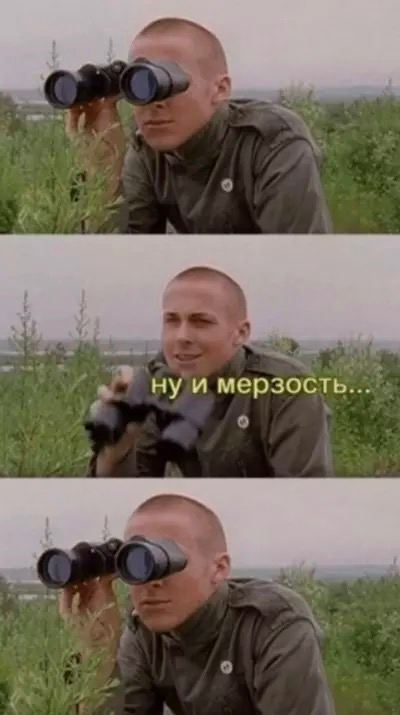

## 2. Приближение одномерной функции многочленом

Начнем с простой задачи.


1) Есть функция $f(x)$, но мы ее не знаем.

2) Зато мы знаем ее значения в $m$ точках (они называются тренировочным множеством):
$$f(x_1) = y_1$$
$$\cdots$$
$$f(x_m) = y_m$$
3) Нужно научиться приблизительно восстанавливать эту функцию.

Самый простой способ - научиться приближать её многочленом, а именно давайте подберем такие коэффициенты $a_0, a_1, \ldots, a_n$, чтобы многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ был как можно ближе к $f(x)$.

Но что такое "приблизить"? Мы знаем лишь значения в $m$ точках, так что в лучшем случае она должна проходить через все эти точки (хотя скоро мы увидим, что это не так).

В этом случае обычно пытаются минимизировать сумму квадратов ошибок во всех точках, то есть **функцию потерь** $$Q(P) = \sum_i (P(x_i) - f(x_i))^2 $$

Эту величину называют **MSE** - Mean Squared Error (средняя квадратичная ошибка).

Тут может возникнуть вопрос, почему мы берем именно сумму квадратов, а не, например, сумму модулей. Однозначного ответа на этот вопрос нет, наиболее удачный ответ, пожалуй такой: у суммы квадратов есть много удобных свойств, например это выпуклая, дифференцируемая функция. Тем не менее иногда другой выбор может быть оправданным. Если вам интересно чуть больше понять про смысл этих условий, можете решить такие задачи:

**(0.5 балла) Доп. Задача 1.** Найдите число m такое, что для заданных $x_i$ сумма $\sum|m - x_i|$ минимальна

>**Решение:**
>
>$\frac{d}{dm}\left(\sum\limits_{i=1}^n\left|m-x_i\right|\right)=\sum\limits_{i=1}^n\text{sign}(m-x_i)=0$. Значит $m$ &mdash; медиана.

**(0.5 балла) Доп. Задача 2.** Найдите число m такое, что для заданных $x_i$ сумма $\sum(m - x_i)^2$ минимальна

>**Решение:**
>
>$\frac{d}{dm}\left(\sum\limits_{i=1}^n\left(m-x_i\right)^2\right)=\sum\limits_{i=1}^n2(m-x_i)=0$. Значит $m=\overline{x}$ &mdash; среднее.

Сейчас можно их и пропустить.


Сначала просто нарисуем какой-нибудь многочлен, например $f(x) = 3x^3 - 2x^2 + x$ на отрезке $[-1, 1]$:

In [11904]:
def f(x):
    return 3 * x ** 3 - 2 * x**2 + x

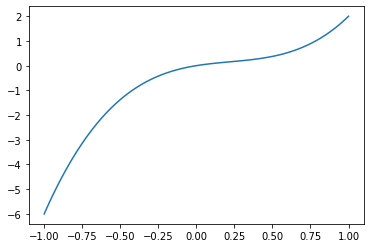

In [11905]:
x100 = np.linspace(-1, 1, 100)
plt.plot(x100, f(x100))
plt.show()

Теперь зададим набор точек (10 штук) и посмотрим что будет, если подобрать по ним коэффициенты нашего многочлена:

In [11906]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)
coefs = np.polyfit(x, y, deg = 2)
coefs

array([-2.00000000e+00,  3.17037037e+00, -9.55004142e-16])

(это означает многочлен $-2x^2 + 3.17037 x$)

numpy позволяет легко работать с многочленами, заданными их коэффициентами. Мы можем создать из них объект poly1d, который можно будет просто вызывать для получения нужных значений:

In [11907]:
poly = np.poly1d(coefs)
poly(0), poly(1), poly(2)

(-9.550041418834e-16, 1.1703703703703714, -1.6592592592592537)

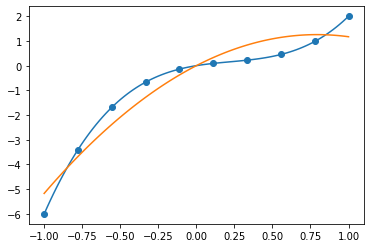

In [11908]:
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

Довольно ожидаемо, наша функция (оранжевая) не очень похожа на то, что мы искали (синяя). Наверное зря мы пытаемся приблизить кубическую функцию многочленом второй степени. Давайте попробуем 3-ю степень.

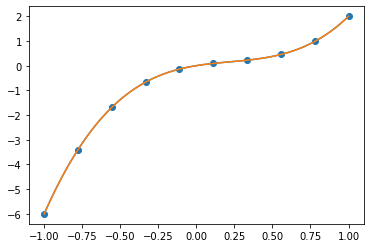

In [11909]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

На этот раз мы в точности угадали функцию. Можете проверить, что если увеличивать степень многочлена, результат не меняется: более высокие степени тут просто не нужны.

Но мы сейчас жили в идеальном мире. На практике чаще всего известные нам значения не совсем точны. Давайте добавим к значениям нашей функции немного шума:

In [11910]:
def f_real(x):
    return 3 * x ** 3 - 2 * x**2 + x + np.random.normal(0, 1, x.shape)

In [11911]:
x.shape

(10,)

In [11912]:
x = np.linspace(-1, 1, 10)
y = f_real(x) # + np.random.normal(0, 0.5, 10)  # случайный шум

In [11913]:
x100 = np.linspace(-1, 1, 100)

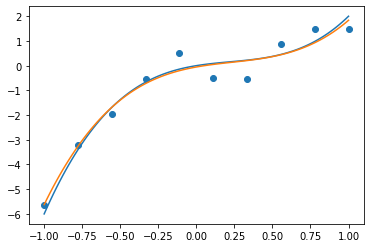

In [11914]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

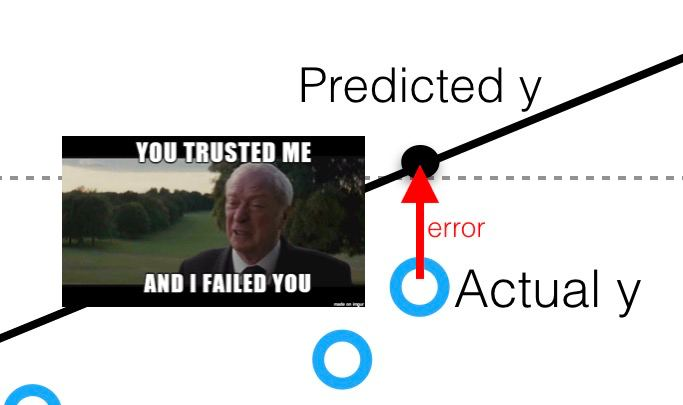

Теперь мы почти попали. Перед тем как читать дальше, подумайте над заданием.

**(1 балл) Обязательное задание 1:** попробуйте увеличить степень полинома. Что произойдет с графиком нашего приближения? Посмотрите  как обе функции себя ведут вне интервала x. Попробуйте сформулировать проблему, с которой мы столкнулись.

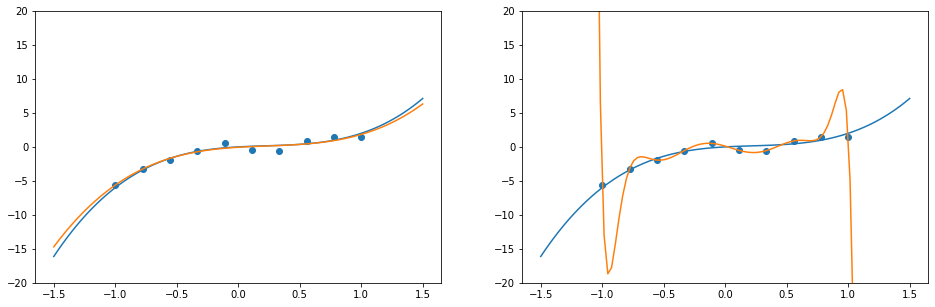

In [11915]:
plt.figure(figsize=(16, 5))

x100 = np.linspace(-1.5, 1.5, 100)

plt.subplot(1, 2, 1)
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.ylim((-20, 20))

plt.subplot(1, 2, 2)
coefs = np.polyfit(x, y, deg = 20)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))

plt.ylim((-20, 20))

plt.show()

>**Вывод:** Увеличив степень аппроксимирующего многочлена мы доститгли того, что функция проходит через все тренировочные точки. Однако данная функция ведёт себя совсем не так, как целевая при отхождении от интервала с тренировочными точками, что говорит о неадекватности такого приближения. В задаче с зашумлёнными данными проблема состоит в том, чтобы обучить модель не слишком слабо и не слишком сильно, для адекватных предсказаний в дальнейшем.

## 3. Переобучение

То, что вы увидели при решении этого задания называется в машинном обучении **переобучением** (overfittig).

Если мы используем достаточно сложную модель (то есть модель, у которой много параметров, в нашем случае &mdash; многочлен достаточно высокой степени), то у модели появляется возможность "выучить" все точки, которые она видела. Например, если задано $m$ точек, всегда можно подобрать многочлен степени $m-1$, который через них проходит (если вы не знакомы с этим фактом, можете подумать, как его доказать).

"Честный" способ проверять качество нашей апроксимации &mdash; **смотреть точность в точках, которые мы не использовали при подборе многочлена**. Это множество часто называют тестовым множеством. Давайте зададим его так:

In [11916]:
# возьмем 10 случайных точек от 0 до 1
x_test = np.random.random(10)

# превратим их в 10 случайных точек от -1 до 1
x_test = 2 * x_test - 1
x_test

array([ 0.98058431,  0.07883565,  0.16409518, -0.14705763,  0.47885949,
       -0.62728015,  0.60573513,  0.73462796, -0.55114312, -0.51651811])

**(1 балл)  Обязательное задание 2:** напишите функцию, которая для данного многочлена считает его качество на тестовом множестве (то есть среднеквадратичное отклонение между значениями функции $f$ и многочлена $P$ на тестовой выборке).

Вы все прошлое занятие изучали разные функции, попробуйте сделать MSE как можно более компактной функцией (желательно в одну строчку).

In [11917]:
# y_real - это np.array c реальными значениями в точках
# y_pred - это np.array c предсказанными нами значениями в точках
# они одной длины
def MSE(y_real, y_pred):
    return ((np.array(y_real) - np.array(y_pred)) ** 2).mean()

**(1 балл) Обязательное задание 3:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?


In [11918]:
y_real_test = f_real(x_test)

In [11919]:
N = 7

coefs = [np.polyfit(x, y, deg = i) for i in range(N)]

y_pred = np.array([np.array([x_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(y_real_test, y_pred[i]) for i in range(N)]

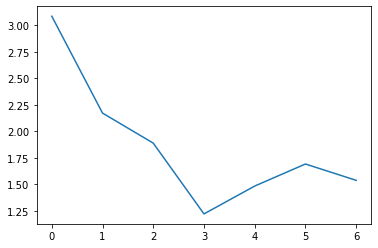

In [11920]:
plt.plot(range(N), mse)

>Наименьшее значение MSE достингается при аппроксимировании многочленом третьей степени в 6 из 10 тестах, что ожидаемо, ведь эта функция должна наиболее адекватно описывать тестовые точки.

**(1 балл) Доп. задача 5:** как меняется график, если увеличивать количество точек в множестве, на котором мы подбираем многочлен?

In [11981]:
x_train = np.linspace(-1, 1, 1000)

y_train = f_real(x_train)

In [11982]:
x_test = np.random.random(10)

x_test = 2 * x_test - 1

y_real_test = f_real(x_test)

In [11983]:
N = 7

coefs = [np.polyfit(x_train, y_train, deg = i) for i in range(N)]

y_pred = np.array([np.array([x_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(y_real_test, y_pred[i]) for i in range(N)]

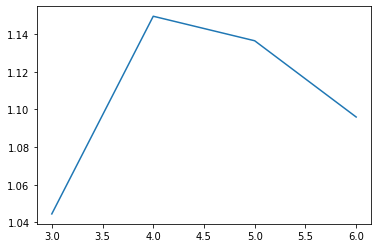

In [11984]:
plt.plot(range(N)[3:], mse[3:])

>У аппроксимаций меньшей степени, чем 3 выросли значения MSE, но в целом особых изменений не обнаружено. Возможно, это связанно с сильным шумом, так как значение шума порядка значений функций на этом отрезке и нельзя точно сказать степень многочлена даже при большом количестве точек.

## 4. Выводы

1. Цель машинного обучения с учителем - приблизить **целевую функцию** (target) по её значениям (возможно приблзительным) в некоторых точках.

В нашем случае - это $f(x) = 3x^3 - 2x^2 + x$. Обычно она, конечно, никому неизвестна.

2. Множество точек с известным значением функции называется **тренировочным множеством** (train).

В нашем случае - это 10 точек, выбранных равномерно на отрезке $[-1, 1]$.

3. Чтобы приблизить функцию, нужно использовать какую-то **модель** (model), приближающую функцию.

В данном случае - это многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$.

4. Мы выбираем **функцию потерь** (loss function) для сравнения результатов модели и реальных значения на тренировочном множестве. Чем она меньше, тем лучше наша модель.

В данном случае - это $MSE = \sum_i (P(x_i) - f(x_i))^2$.

5. У модели есть **параметры**, которые мы выбираем так, чтобы функция потерь на тренировочном множестве была минимальна.

В данном случае - это коэффициенты многочлена ($a_0, a_1, \ldots, a_n$). Выбираются они с помощью пока магической для нас функции polyfit.

6. У модели есть **гиперпараметры**, которые мы выбираем сами.

В данном случае - это степень многочлена (число $n$).

7. Однако такой подход с минимизацией функции потерь может привести к тому, что мы идеально приблизим функцию на тренировочном множестве, но она будет абсолютно отличаться во всех остальных точках. Это явление называется **переобучением**.

В данном случае - мы видели, что если степень многочлена большая (больше трех), то мы попадаем во все точки, но при этом сам многочлен сильно отличается от $f(x)$.

8. Чтобы бороться с переобучением, полезно выделить **тестовое множество** точек, в которых мы тоже знаем результаты функции. Оно никак не используется при обучении модели, и нужно только для валидации результата.

В данном случае - мы взяли рандомные 10 точек на отрезке $[-1, 1]$.

9. В идеальном случае функция потерь на тренировочном и тестовом множестве не отличается. А вот если на тренировочном функция потерь получается гораздо меньше, чем на тестовом, то это говорит о том, что происходит переобучение.

Действительно, при большой степени MSE близка к или равна нулю на тренировочном множестве, а на тестовом множестве нет.

10. Единственный пока способ, который мы знаем, чтобы влиять на переобучение - это перебирать **гиперпараметры** модели так, чтобы **минимизировать функцию потерь на тестовом множестве**.

Действительно, если выбрать степень 3, то функция потерь окажется минимальной на тестовом множестве, как мы видели в задании 3.

## 5. Разделение на тренировочную и тестовую части

Если вы решите поучаствовать в каком-нибудь соревновании по машинному обучению, вы увидите, что тестовое множество вам недоступно (иначе было бы неинтересно: очень легко обучиться предсказывать то, что ты уже видел).

В реальной жизни обычно тоже считают, что на тестовом множестве можно провериться один раз &mdash; в самом конце. Иначе вы начнете подкручивать гиперпараметры глядя на результат на тестовой выборке и, сами того не замечая, переобучитесь.

Как поступать в такой ситуации? Придется пожертвовать частью точек, которые даны нам для обучения и использовать их для подбора гиперпараметров в нашем алгоритме (в нашем случае это степень многочлена).

То есть придется из точек, у которых мы знаем результаты, убрать, например, 10% в тестовое множество.

Функция для этого есть, например, в пакете sklearn

In [12006]:
X = np.linspace(-1, 1, 50)
y = f_real(X)

In [12007]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [12008]:
X_train, y_train

(array([-0.18367347,  0.30612245, -0.42857143,  0.18367347,  0.91836735,
         0.95918367,  0.71428571, -0.59183673, -0.83673469, -0.34693878,
         0.63265306,  0.10204082, -0.02040816, -0.10204082,  0.46938776,
         0.02040816, -0.55102041,  0.59183673, -0.46938776, -1.        ,
         0.67346939,  0.26530612,  0.3877551 ,  0.87755102,  1.        ,
         0.51020408, -0.75510204,  0.55102041,  0.42857143, -0.30612245,
        -0.51020408, -0.3877551 , -0.63265306, -0.79591837, -0.95918367,
        -0.91836735, -0.26530612,  0.75510204,  0.14285714,  0.2244898 ,
         0.34693878, -0.87755102, -0.2244898 , -0.67346939,  0.06122449]),
 array([ 1.40138716,  1.02643249, -0.73503622,  0.58375631, -2.17182423,
         1.12026136,  0.39539848, -1.24228089, -3.53884704, -2.66712528,
        -1.42705198,  0.35179578,  0.65761534, -1.46432981, -0.8498872 ,
        -0.32991289, -1.58148714, -0.82935587, -2.16613416, -4.214218  ,
         0.20178072,  0.9099037 , -0.31853083,  3

In [12009]:
X_test, y_test

(array([-0.71428571, -0.14285714,  0.83673469,  0.79591837, -0.06122449]),
 array([-2.898765  ,  0.16164652,  0.47218935,  1.65324964, -0.034121  ]))

## 6. Кросс-валидация

Также есть более точный способ проводить валидацию результата. Если разделить множество один раз на тестовое и тренировочное, то это может значительно влиять на результат. Вдруг в тестовое множество случайно попали такие точки, в которых предсказать значение тяжелее или легче, чем обычно?

Тогда можно применить **кросс-валидацию** - давайте разделим множество на 10 примерно равных частей, тогда у нас есть 10 разделений на тренировочное и тестовое множество - как тестовое множество выберем по очереди каждую из этих частей, а как тренировочное выберем все остальные части. В итоге, все элементы множества побывают и в тренировочной, и в тестовой чати.

Можно посчитать результат на каждом из 10 разбиений и просто усреднить результат.


In [12010]:
# Есть вот такая удобная штука
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    print(test_index, train_index)

[0 1 2 3 4] [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[5 6 7 8 9] [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[10 11 12 13 14] [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[15 16 17 18 19] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[20 21 22 23 24] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[25 26 27 28 29] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[30 31 32 33 34] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

**(1 балл) Доп. задача 6:** проделайте все вышеописанное с функцией $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3, 3]$. Как оптимальная степень зависит от количества точек, по которым вы подбираете многочлен?

1. Построить заданную функцию

2. Взять 10 точек от -3 до 3 и приближать её полиномом разной степени, построить график ошибки

3. Взять 10 случайных точек от -3 до 3 и посмотреть ошибку на этих точках полиномиальных функций обученных по пункту 2 (т.е. взять тренировочные точки для обучения из пункта 2, а тестировать случайными точками) построить график.

4. Добавить в функцию случайный шум и проделать пункты 2 и 3 для неё.

5. Увеличить количество тренировочных(только тренировочных) точек с 10 например до 20 40 60. И проделать пункты 2 и 3, для этих сэмплов

6. Сделать выводы.

In [12011]:
def f(x):
    return 1 / (1 + np.exp(-x))

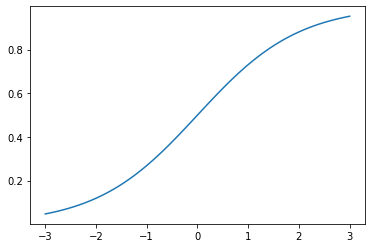

In [12012]:
x = np.linspace(-3, 3, 100)

plt.plot(x, f(x))

In [12126]:
X = np.random.uniform(-3, 3, 20)
Y = f(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [12118]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_train ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_train, Y_pred[i]) for i in range(N)]

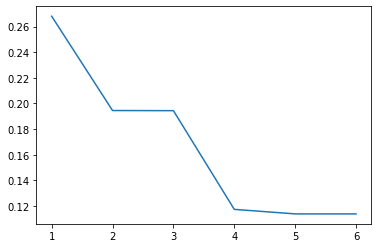

In [12105]:
plt.plot(range(N)[1:], mse[1:])

In [12127]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_test, Y_pred[i]) for i in range(N)]

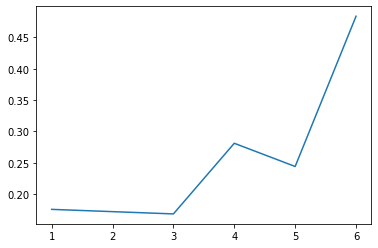

In [12128]:
plt.plot(range(N)[1:], mse[1:])

>Как и ожидалось, у многочленов чётного порядка ошибка выше, так как целевая функция нечётная.

Добавим шум

In [12144]:
def f_real(x):
    return 1 / (1 + np.exp(-x)) + np.random.normal(0, 0.5, x.size)

In [12185]:
X = np.random.uniform(-3, 3, 20)
Y = f_real(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [12188]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_train ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_train, Y_pred[i]) for i in range(N)]

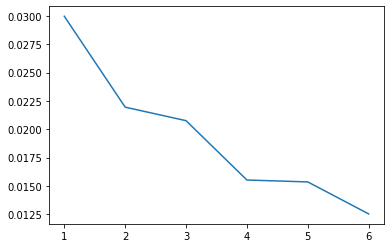

In [12189]:
plt.plot(range(N)[1:], mse[1:])

In [12186]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_test, Y_pred[i]) for i in range(N)]

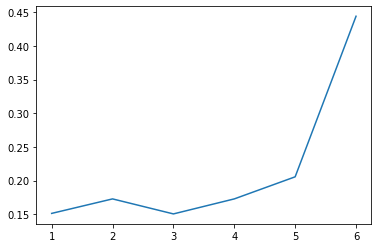

In [12187]:
plt.plot(range(N)[1:7], mse[1:7])

>В зашумлённых данных уже нельзя сказать, что чётные степени явно хуже. Однако из-за малого количества тренировочных точек многочлены высокх степеней стали себя хуже вести (так как они лучше подстраиваются). Ожидаемо лучшей оказалось аппроксимация кубической параболой, так у неё также только одна точка перегиба, что позволяет шумным данным подстроится под характерное для изначальной функции поведение.

Изменим размер сэмпла

* $n=20$

In [12190]:
X = np.random.uniform(-3, 3, 30)
Y = f_real(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 3)

In [12191]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_train ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_train, Y_pred[i]) for i in range(N)]

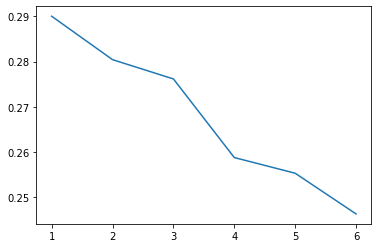

In [12192]:
plt.plot(range(N)[1:], mse[1:])

In [12193]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_test, Y_pred[i]) for i in range(N)]

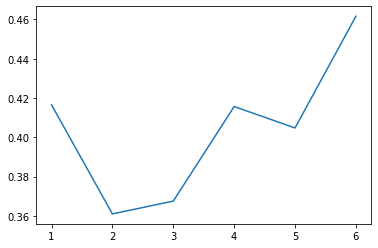

In [12194]:
plt.plot(range(N)[1:], mse[1:])

* $n=40$

In [12195]:
X = np.random.uniform(-3, 3, 50)
Y = f_real(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [12196]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_train ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_train, Y_pred[i]) for i in range(N)]

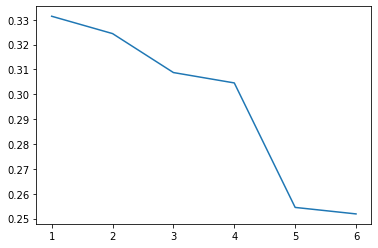

In [12197]:
plt.plot(range(N)[1:], mse[1:])

In [12198]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_test, Y_pred[i]) for i in range(N)]

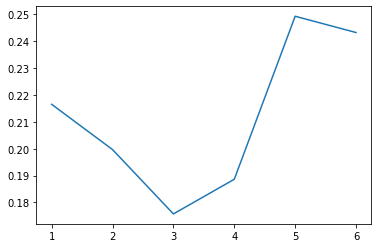

In [12199]:
plt.plot(range(N)[1:], mse[1:])

* $n=60$

In [12200]:
X = np.random.uniform(-3, 3, 30)
Y = f_real(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 6)

In [12201]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_train ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_train, Y_pred[i]) for i in range(N)]

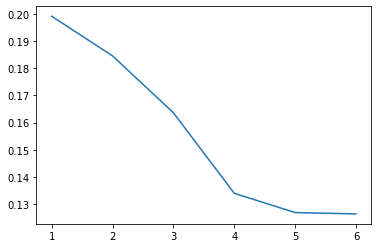

In [12202]:
plt.plot(range(N)[1:], mse[1:])

In [12203]:
N = 7

coefs = [np.polyfit(X_train, Y_train, deg = i) for i in range(N)]

Y_pred = np.array([np.array([X_test ** num * val for num, val in enumerate(coefs[i][::-1])]).sum(axis=0) for i in range(N)])

mse = [MSE(Y_test, Y_pred[i]) for i in range(N)]

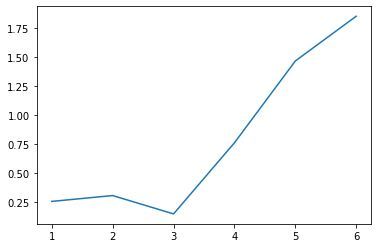

In [12204]:
plt.plot(range(N)[1:], mse[1:])

>Как видно, значение MSE уменьшается с увеличение выборки, также ногочлены степени выше 3 стали давать меньшее значение MSE чаще. Это связанно с тем, что у модели больше данных для обучения и она может лучше подбирать коэффициенты. Однако всё равно многочлен степени три остаётся приоритетным для описания данных (не исключено, что в ситуациях, когда у высоких  степеней MSE ниже, у них малые коэффициенты при высоких степенях $x$).

>**Вывод:** При вычислении ошибки на тренировочных данных мы можем наблюдать, что многочлены высоких степеней эффективнее, однако тестовые данные демонстрируют, что при степени больше 3 зачастую происходит переобучение. Также на размер ошибки влияет размер выборки: чем больше выборка, тем меньше ошибка.

## 7. Линейная регрессия на реальных данных

До этого мы учились приближать одномерную функцию многочленом. Каждая точка имела ровно один признак - коодинату $x$.

Тем не менее, чаще всего в машинном обучении признаков гораздо больше. Возьмем какой-нибудь реальный датасет.

In [12205]:
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


В датасете показаны результаты продаж разных товаров в зависимости от ресурсов (тысяч долларов), которые вложили в различные средства распространения информации:
* TV - реклама по телевизору
* radio - на радио
* newspapers - в газетах

Целевая переменная:

sales - продажи такого-то товара (тысячи штук)

In [12206]:
# Размеры датасета
data.shape

(200, 4)

In [12207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [12208]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Признаков немного, поэтому давайте попробуем визуализиовать зависимость целевой переменной от каждого из признаков.

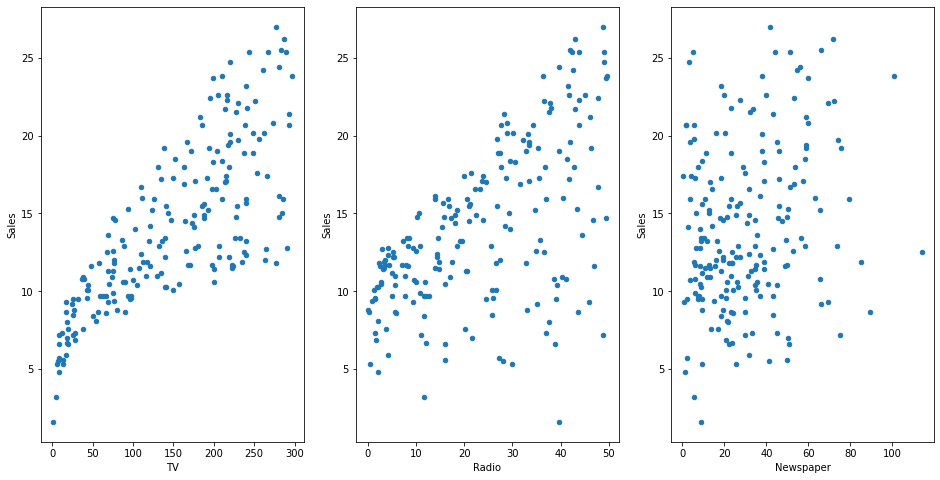

In [12209]:
fig, axs = plt.subplots(1, 3,)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

### Простая линейная регрессия

Из графиков выше предположим, что только размер рекламы на телевизоре влияет на продажи больше всего. Формула для такого случая выглядит следующим образом:
$$y=\beta_0+\beta_1x$$
Здесь:
* $y$ - наше предсказание продаж
* $x$ - сколько денег вложили в рекламу по телевидению
* $\beta_0$ - сдвиг
* $\beta_1$ - параметр, отвечающий за важность признака x

$\beta_0$ и $\beta_1$ - это параметры нашей модели. Чтобы создать хорошую модель, надо "обучить" эти значения. Т.е. изменить их так, чтобы они хорошо работали для нашей задачи.

### Обучение коэффициентов модели

Параметры $\beta_0$ и $\beta_1$ подбираются таким образом, чтобы минимизировать **сумму наименьших квадратов ошибок**:

$$Q(MSE)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

<img src="https://i.pinimg.com/originals/95/99/b0/9599b04198dc617282026d00a6e8f9d4.png">

* Фиолетовые точки на даграмме $y^{true}$ - это полученные истинные значения x и y .
* Синяя линия $y^{pred}$ - это наша модель: линия, которой мы стараемся приблизить данные .
* Красные отрезки - это ошибки нашей модели.


Как коэффициенты $\beta_0$ и $\beta_1$ соотносятся с синей линией:
* $\beta_0$ - это сдвиг нашей прямой, т.е. значение y при x = 0.
* $\beta_1$ - это тангенс угла наклона прямой.

Как искать данные коэффициенты? Есть много техник: аналитическое решение, методы основанные на градиентном спуске. Пока же достаточно знать, что многие библиотеки (в том числе и sklearn) умеют это делать. Зачем кожаному мешку напрягаться :)

In [12210]:
from sklearn.linear_model import LinearRegression

# Наша модель
reg = LinearRegression()

# Подготовим данные для неё
# На вход требуется 2D матрица, а у нас только один признак,
# и надо превратить его из 1D вектора (n,) в 2D матрицу (n, 1).
# Это можно сделать с помощью метода reshape
x = data["TV"].values.reshape(-1, 1) 
y = data["Sales"].values

# Обучаем нашу модель
reg.fit(x, y)

# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
print("Массив коэффициентов={}".format(reg.coef_))

Сдвиг=7.0325935491276885
Массив коэффициентов=[0.04753664]


### Интерпретируем коэффициенты
Что означает коэффициент, связанный с телевидением ($\beta_1$)?
* Дополнительные 1000 000$, вложенные на в рекламу на телевидении, позволят продажам товара вырасти где-то на 0.047 * 1000 = 47 тысяч единиц.

In [12211]:
# Посчитаем ручками
7.032594 + 0.047537*1000

54.56959400000001

In [12212]:
X_new = pd.DataFrame({'TV': [1000]})
X_new.head()

,TV
0,1000


In [12213]:
reg.predict(X_new)

array([54.56923398])

### Нарисуем нашу прямую

In [12214]:
# Возьмём предсказания для данных, на которых обучались
y_pred = reg.predict(x)
y_pred.shape

(200,)

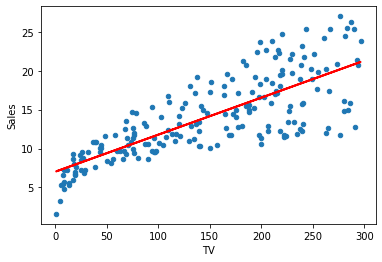

In [12215]:
# Сначала выведем истинные данные
data.plot(kind='scatter', x='TV', y='Sales')

# Теперь рисуем нашу линию
plt.plot(x, y_pred, c='red', linewidth=2)
plt.show()

Посчитаем ошибку MSE на обучающей выборке:


In [12216]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_pred, y))

10.512652915656757


### Используем все признаки

Простую линейную регрессию с одним признаком можно легко расширить на случай нескольких признаков:
$$y=\beta_0+\beta_1x_1+...+\beta_nx_n$$

А для нашего датасета это будет выглядеть так:
$$Sales=\beta_0+\beta_1*TV+\beta_2*radio+\beta_3*newspaper$$

Давайте опять воспользуемся sklearn, чтобы их оценить:

In [12217]:
reg = LinearRegression()

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Обучаем нашу модель
reg.fit(X, y)

# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))

Сдвиг = 2.9388893694594014
Коэффициент для TV = 0.04576464545539764
Коэффициент для Radio = 0.18853001691820453
Коэффициент для Newspaper = -0.0010374930424762346


Вес признака отвечает также, как и в предыдущем случае за значимость этого признака. Для газет он вообще отрицательный. Вычислим ошибку на обучающей выборке.

In [12218]:
y_pred = reg.predict(X)

# Ошибка теперь равна:
print(mean_squared_error(y_pred, y))

2.784126314510936


Ошибка уже меньше, чем при одном признаке, однако измерять ошибку на обучающей выборке неправильно. Помимо истинной зависимости между признаками и целевой переменной, туда могут затесаться случайности, лишние данные и прочие факторы. Если не ограничивать каким-то образом модель (об этом мы узнаем позднее), то модель легко подстраивается под эти шумы. Она начинает показывать очень хорошее качество на обучающей выборке, но когда мы попробуем посмотреть качество на других выборках, то там модель будет показывать себя плохо. Это и есть переобучение.

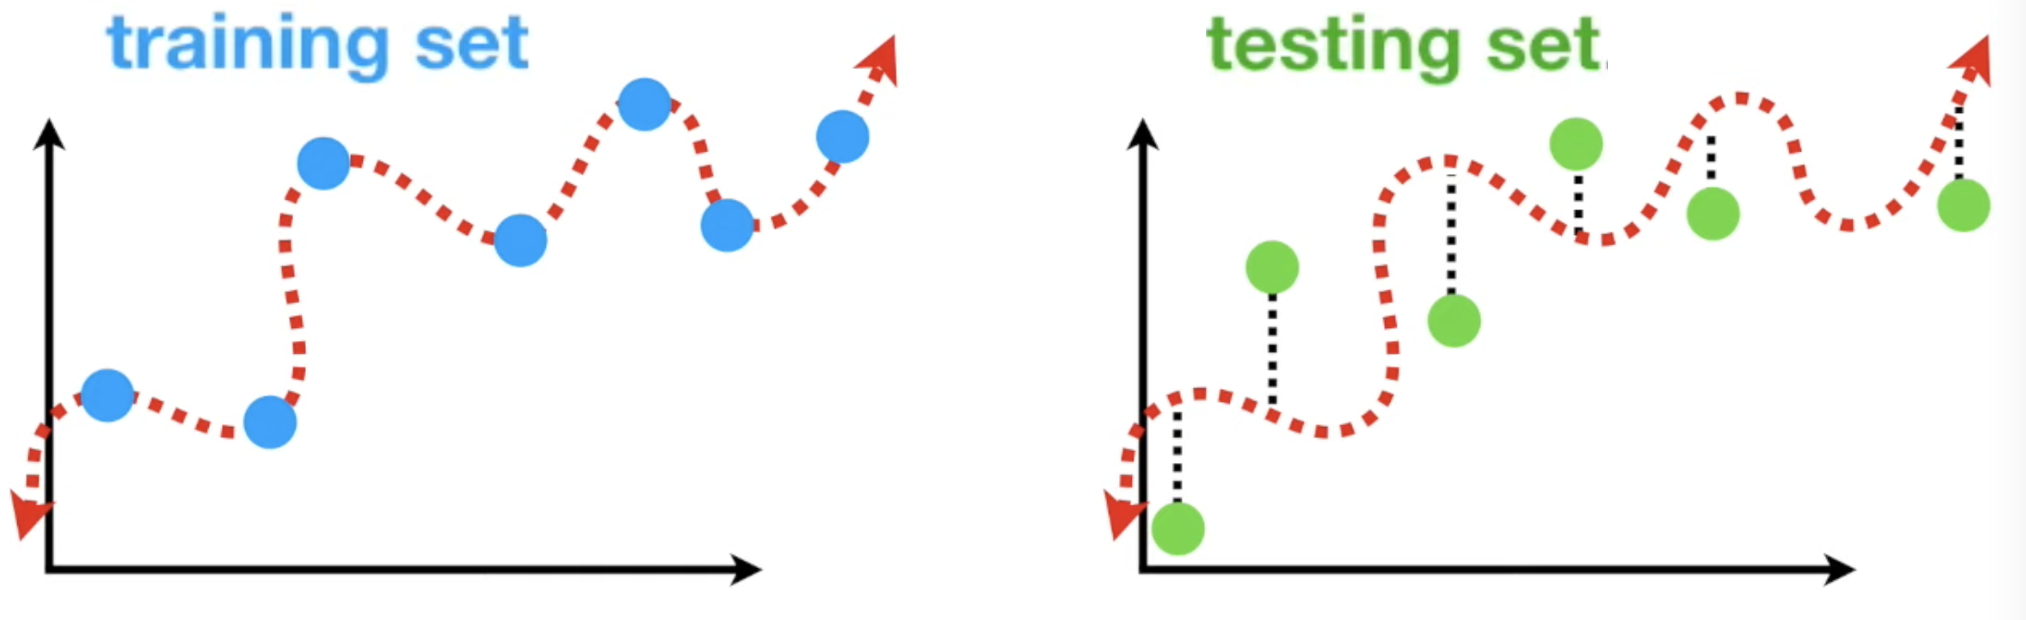

Поэтому применим кросс-валидацию:

In [12219]:
# Многие выбирают k=5 для начала
k = 5
errors = []

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Размер одной части
fold_size = len(X) // k


for i in range(k):
    # Берём все значения, кроме выбранной части
    X_train = X[:i * fold_size].append(X[(i + 1) * fold_size:])
    y_train = y[:i * fold_size].append(y[(i + 1) * fold_size:])
    
    # Берём выбранную часть
    X_test = X[i * fold_size:(i + 1) * fold_size]
    y_test = y[i * fold_size:(i + 1) * fold_size]
    
    # На каждой итерации обучаемся отдельно и сохраняем ошибку
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    errors.append(mean_squared_error(y_pred, y_test))
    
# Выводим ошибку на кросс-валидации
print(np.mean(errors))

3.072946597100208


In [12220]:
# А можно не париться и попросить sklearn всё сделать за нас
from sklearn.model_selection import cross_val_score

# Берём с отрицательным знаком, т.к. обычно туда передаётся не функция потерь, которую надо минимизировать
# А что-то вроде "функции успеха", которую надо максимизировать
errors = -cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

3.072946597100208


Видно, что ошибка больше, чем тогда на обучающей выборке, поэтому есть показания думать, что это переобучение. Отчего оно обычно происходит? Мы берём слишком много лишних признаков или делаем модель слишком сложной для данной задачи. Для решения этой задачи существует регуляризация.

### Регуляризация

Регуляризация - это искусстенное занижение всех параметров моделей ($\beta_0,\beta_1,...$). Это помогает упростить модель, т.к. низкие значения $\beta_i$ означают, что модель будет выдавать результаты близкие к прямой (или гиперплоскости, если параметров много). А также зануление некоторых коэффициентов может убрать ненужные признаки из обучения. Однако как всё это сделать так, чтобы не убрать нужные признаки?

Посмотрим на функцию потерь, которую мы минимизируем:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

Добавим туда слагаемое, которое поможет нам понизить значения наших $\beta_i$:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m\beta_i^2$$

Действительно, если мы будем понижать нашу функцию потерь $L(\beta)$, то мы будем минимизировать и второе слагаемое, которое и отвечает за абсолютные величины $\beta_i$. Осталось указать, что $\lambda$ это некоторый числовой коэффициент, который позволяет играться между очень сильной и очень слабой регуляризацией. Если он большой, то регуляризация сильная и модель будет более простой, меньше переобучаться, больше недообучаться, и наоброт. 

Забыл добавить, что это была L2-регуляризация.
L1-регуляризация выглядит так:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m|\beta_i|$$
Она отличается от L2 тем, что она обнуляет некоторые коэффициенты, а L2 пытается всё уменьшать равномерно.

В sklearn L1-регуляризация - это Lasso, а L2-регуляризация - это Ridge. Давайте посмотрим, какое качество они нам дадут на кросс-валидации.

In [12221]:
# L1
from sklearn.linear_model import Lasso

reg = Lasso( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))
print()

errors = -cross_val_score(Lasso(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг=3.040215583480377
Коэффициент для TV=0.045661415380019485
Коэффициент для Radio=0.18346439758868247
Коэффициент для Newspaper=0.0

Результат=3.0414058967513684


Видно, что признак с рекламой в газетах модель захотела полностью убрать из выборки.

In [12222]:
# L2
from sklearn.linear_model import Ridge

reg = Ridge( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))
print()

errors = -cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг = 2.938967458330147
Коэффициент для TV = 0.04576464365801849
Коэффициент для Radio = 0.18852509681078544
Коэффициент для Newspaper = -0.001036293958906979

Результат=3.072932673298497


In [12223]:
reg.coef_

array([ 0.04576464,  0.1885251 , -0.00103629])

Тут модель полностью не зануляла все признаки, а уменьшила их веса некоторых из них, а некоторых увеличила. Но изменения были столь незначительные, что качество не изменилось.

Как видно, качество не сильно улучшилось. Это всё потому что, мы не подбирали параметр параметр lambda (в моделях он называется alpha), а оставили его равным 1.0. Вот тут нам и приходит на помощь кросс-валидация.

Попробуем сначала Lasso. Давайте сначала поступим по тупому, и будем выбирать параметр lambda на обучающей выборке.

In [12224]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    reg = Lasso(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, mean_squared_error(y_pred, y)))
    print(((val, mean_squared_error(y_pred, y))))
    

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

# Вычислим ошибку на кросс-валидации
# Лучшая модель
best_reg = Lasso(alpha=min_val)
cv_error = -np.mean(cross_val_score(best_reg, X, y, cv=5, scoring='neg_mean_squared_error'))

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, cv_error))

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2.7842286851696874)
(0.30000000000000004, 2.784985993046453)
(0.5000000000000001, 2.7857256993570267)
(0.7000000000000001, 2.7868352725638887)
(0.9000000000000001, 2.7883147049707757)
(1.1000000000000003, 2.790163996577687)
(1.3000000000000003, 2.7923831473846246)
(1.5000000000000004, 2.7949721573915864)
(1.7000000000000004, 2.797931026598574)
(1.9000000000000004, 2.8012597550055864)
(2.1000000000000005, 2.804958342612624)
(2.3000000000000007, 2.809026789419686)
(2.5000000000000004, 2.813465095426773)
(2.7000000000000006, 2.8182732606338856)
(2.900000000000001, 2.8234512850410227)

Оптимальная lambda:
Lambda=0.10, результат=3.07


А теперь сделайте так, чтобы сохранялась ошибка не на обучающей выборке, а на кросс-валдиации (cross_val_score) и минимум выбирался из неё. 

**(0.5 балла) Обязательное задание 4:** нарисуйте график зависимости ошибки на тестовом множестве от коэффициента регуляризации. При какой степени ошибка минимальна?

In [12225]:
lambdas = np.arange(0.1, 3.0, 0.2)

lambda_errors = np.empty((lambdas.size, 2))

k = 5
fold_size = len(X) // k

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=1.90, результат=3.03


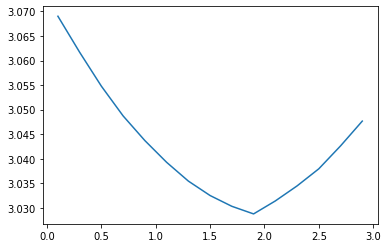

In [12226]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

**(0.5 балла) Обязательное задание 5:** Сделайте то же самое для L2-регуляризации:

In [12227]:
lambdas = np.arange(0, 2000.0, 1)

lambda_errors = np.empty((lambdas.size, 2))

k = 5
fold_size = len(X) // k

for num, val in enumerate(lambdas):

    reg = Ridge(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=900.00, результат=3.07


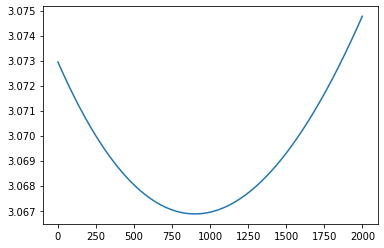

In [12228]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

Если всё было правильно, то данные манипуляции помогут немного улучшить качество вашей модели. Это поднимет вас на несколько мест в соревнованиях, или вашему работодателю даст побольше прибыли.

## P.S. meme

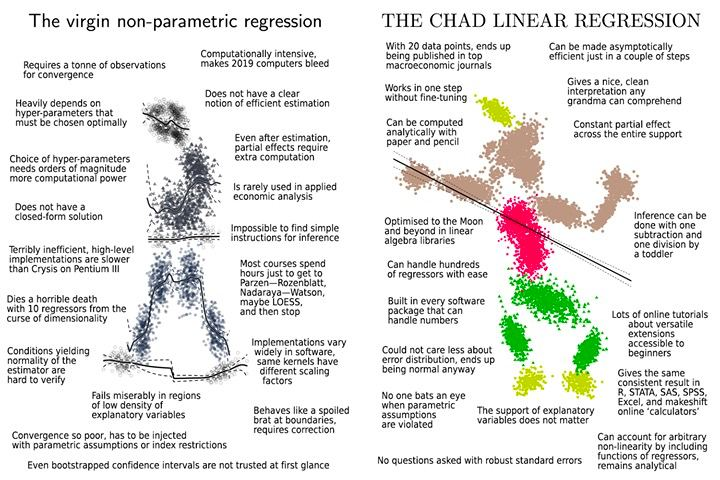

## Дополнительные материалы для самостоятельного изучения

* Визуальное представление основ линейной алгебры [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab). (рус. субтитры)

* Визуальное представление основ математического анализа [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr). (рус. субтитры)

# Основное домашнее задание (6 баллов + гешефт за улучшения)

Для домашнего задания вы используете другой датасет.

In [12229]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


В датасете приводится информация о пациентах и их состоянии при заболевании диабетом. Описание признаков можно прочитать [здесь](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Колонка Y - целевая переменная:

In [12230]:
target = 'Y'
X = data.drop([target], axis=1)
y = data[target]

X.shape, y.shape

((442, 10), (442,))

**Ваша задача** - провести то же исследование, что и в датасете в самом начале (Sales ~ TV, Radio, Newspaper). В итоге, нужно получить модель линейной регрессии, качество которой надо вывести с помощью cross_val_score с метрикой MSE (тоже самое в общем).

**Целевая метрика - MSE**

За каждое достойное улучшение качества на cross_val_score будут доп. баллы. Не забудьте описать, что использовали, что получилось и нет, а также попробуйте понять почему. Побольше гуглите. 

Возможные улучшения:
* Нормализация данных: вычитаем из каждой колонки её среднее и делим на стандартное отклонение.
* Пробуйте убрать ненужные признаки.
* Можно перемножать некоторые признаки.
* Погуглите что-то вроде "improve linear regression".

В общем, представьте, что вы работаете датасаентистом, получаете *300K bucks*, а вам сказали, что нужно как можно лучше уметь предсказывать такие данные.

<img src="https://c.tenor.com/JZ1XdjdbHs8AAAAC/futurama-fry.gifhttps://c.tenor.com/3M8C_1GPijcAAAAC/master-gachi.gif">

>### Зависимость целевой переменной от признаков

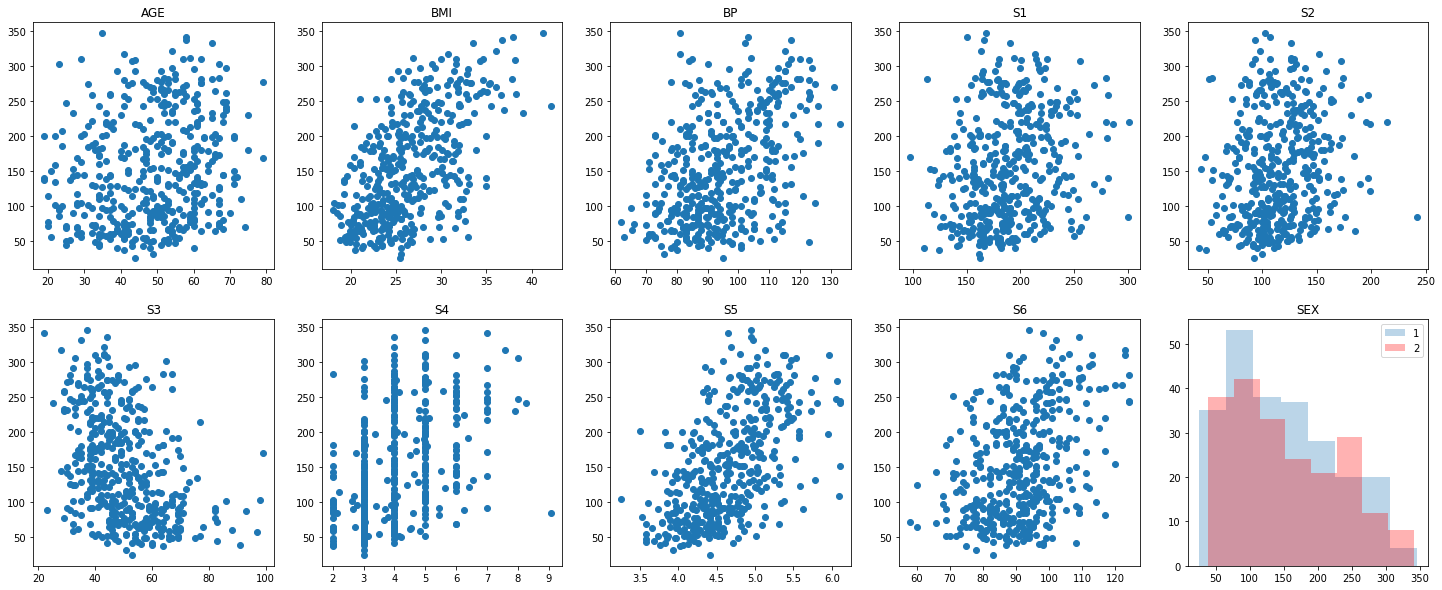

In [12231]:
plt.figure(figsize=(25, 10))

for num, val in enumerate(data.columns[(data.columns != 'SEX') * (data.columns != 'Y')]):
    plt.subplot(2, 5, num + 1)
    plt.scatter(data[val], data['Y'])
    plt.title(val)

plt.subplot(2, 5, 10)
plt.hist(data[data['SEX'] == 1]['Y'], alpha=0.3, label='1', bins=8)
plt.hist(data[data['SEX'] == 2]['Y'], alpha=0.3, color='red', label='2', bins=8)
plt.legend()
plt.title('SEX')

plt.show()

>Как видно из гистограммы пол особо не влияет на развитие диабета. Наиболее влиятельными факторами выглядят BMI, BP, S5, S3. Возраст, кажется, не особо влияет. Остальные параметры под вопросом.

>### Выбор и применение модели

>Так как у нас есть признаки, от которых целевая переменная не зависит, то применим $L_1$ регуляризацию. Потом для сравнения попробуем модель $L_2$ модель и модель вообще без регурялизации без признаков отобранных ранее. И в конце снова используем $L_1$ для сравнения.

* $L_1$ регурялизация

In [12232]:
lambdas = np.arange(-0.0282, -0.0281, 0.000001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:7f}, результат={:7f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=-0.028165, результат=2993.030877


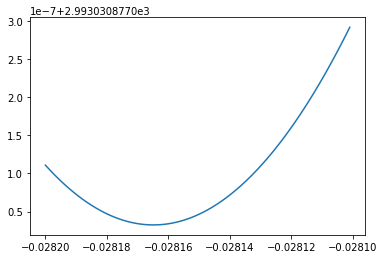

In [12233]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

In [12234]:
a = reg.fit(X, y)
pd.DataFrame(zip(data.columns[:-1], a.coef_))

,0,1
0,AGE,-0.036962
1,SEX,-23.011609
2,BMI,5.595860
3,BP,1.117632
4,S1,-1.133596
5,S2,0.783826
6,S3,0.427007
7,S4,6.752743
8,S5,69.650485
9,S6,0.278639


>Как оказалось, пол играет очень важную роль и без него cross_val_score вырастает на 100 едениц, поэтому занесём его в группу влиятельных признаков вместо S3. Также к ним можно отнести S1 и S4 и, пожалуй, S2. Остальные признаки и правда оказались неважными.

>Теперь оставим только важные признаки

In [12235]:
X = data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1)

* $L_2$ регурялизация

In [12236]:
lambdas = np.arange(-0.05, -0.04, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Ridge(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=-0.04293, результат=2944.89797


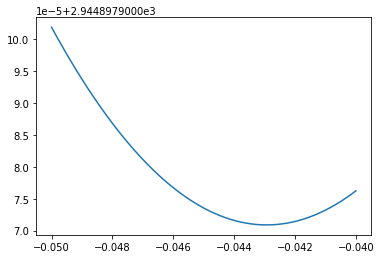

In [12237]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

>Как видно, значение cross_val_score удалось уменьшить на 50 едениц.

* Без регурялизации

In [12238]:
reg = LinearRegression()

cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

print("Результат={:.5f}".format(min_test_error))

Результат=2944.89797


* Снова $L_1$ регурялизация

In [12239]:
lambdas = np.arange(0.009, 0.01, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=0.00923, результат=2944.89741


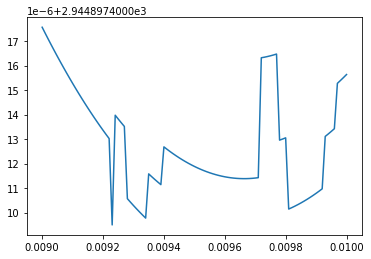

In [12240]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

>**Вывод:** С помощью отбора важных параметров удалось повысить качество модели. Теоретический отбор параметров не полностью совпал с наилучшим, однако тоже дал результат. После отбора параметров все модели дали примерно одинаковый результат в плане точности, но модель с $L_1$ регурялизаций окозалась наиболее точной.

>### Нормализация данных

>Попробуем улучшить результат путём нормализации данных. Опираясь на предыдущее исследование будем работать только с важными признаками и $L_1$ регурялизацией.

In [12241]:
X = (data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1) - data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).mean()) / data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).std()

In [12242]:
lambdas = np.arange(-0.062, -0.061, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=-0.06145, результат=2944.61532


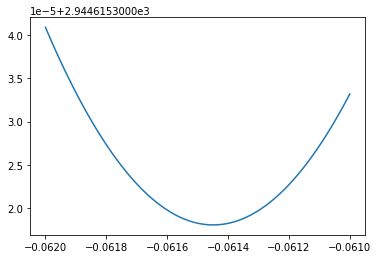

In [12243]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

>Получилось ещё немного улучшить результат.

>### Комбинирование признаков

>Из графика для BMI заметно, что зависимость нелинейная. Попробуем прологарифмировать.

Text(0.5, 1.0, 'LOG BMI')

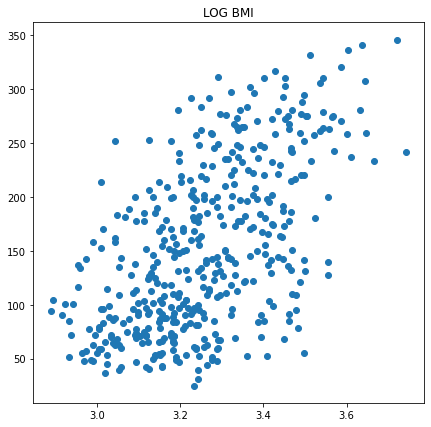

In [12244]:
plt.figure(figsize=(7, 7))
plt.scatter(np.log(data['BMI']), data['Y'])
plt.title('LOG BMI')

>Стало более линейно. Попробуем применить это.

In [12245]:
data['LOGBMI'] = np.log(data['BMI'])
X = (data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1) - data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).mean()) / data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).std()

In [12246]:
lambdas = np.arange(0.028, 0.029, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=0.02831, результат=2923.48566


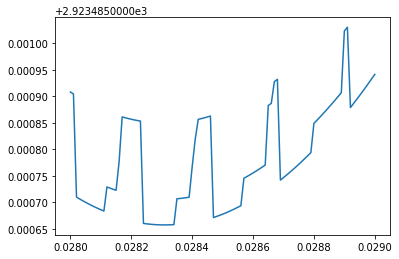

In [12247]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

>Ура!

>Также S2 выглядит подозрительно похожим на экспоненту. ЛОГАРИФМИРУЕМ!!!

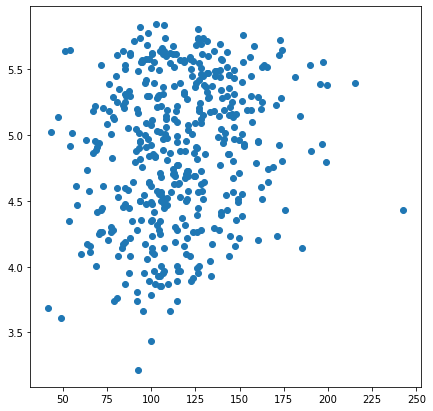

In [12248]:
plt.figure(figsize=(7, 7))
plt.scatter(data['S2'], np.log(data['Y']))
k = np.polyfit(data['S2'], np.log(data['Y']), deg=1)

In [12249]:
data['EXPS2'] = np.exp(k[0] * data['S2'] + k[1])
X = (data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1) - data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).mean()) / data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).std()

In [12250]:
lambdas = np.arange(-1, 2, 0.1)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=0.10000, результат=2946.78187


>Результата не дало.

>Обычно повышенное давление и вес связанны, поэтому попробуем их перемножить.

In [12251]:
data = data.drop('EXPS2', axis=1)

In [12252]:
data['BMIBP'] = data['BMI'] * data['BP']
X = (data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1) - data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).mean()) / data.drop(['AGE', 'S3', 'S6', 'Y'], axis=1).std()

In [12253]:
lambdas = np.arange(0.108, 0.109, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=0.10887, результат=2894.74106


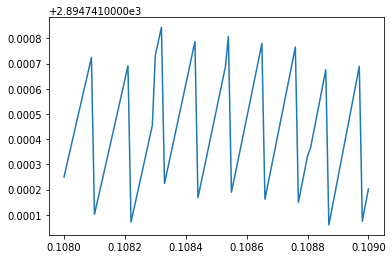

In [12254]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

In [12255]:
Lasso(min_val).fit(X, y).coef_

array([-10.95927677,   0.        , -18.08744569, -27.66422493,
        16.68329196,   6.84414862,  33.02827055, -13.72371181,
        60.93372183])

>ОГО, перед BMI обнулился коэффициент....

In [12256]:
data['BMIBP'] = data['BMI'] * data['BP']
X = (data.drop(['AGE', 'S3', 'S6', 'Y', 'BMI'], axis=1) - data.drop(['AGE', 'S3', 'S6', 'Y', 'BMI'], axis=1).mean()) / data.drop(['AGE', 'S3', 'S6', 'Y', 'BMI'], axis=1).std()

In [12257]:
lambdas = np.arange(0.0005, 0.0006, 0.00001)

lambda_errors = np.empty((lambdas.size, 2))

for num, val in enumerate(lambdas):

    reg = Lasso(alpha=val)

    cv_error = -np.mean(cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))

    lambda_errors[num] = (val, cv_error)

min_val, min_test_error = min(lambda_errors, key=lambda x: x[1])

print("\nОптимальная lambda:")
print("Lambda={:.5f}, результат={:.5f}".format(min_val, min_test_error))


Оптимальная lambda:
Lambda=0.00054, результат=2880.35347


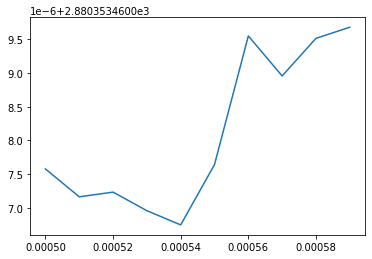

In [12258]:
plt.plot(lambda_errors[:, 0], lambda_errors[:, 1])

In [12259]:
a = Lasso(min_val).fit(X, y)
a.coef_

array([-11.20317489, -25.95692428, -31.58150774,  21.27013226,
         5.37266642,  35.07335814, -23.00317596,  74.8582517 ])

>Это фантастика!

>**Вывод:** Пользуясь теоретическими сображениями и смотря на важность поарамметров из результатов фитирования, мы смогли добиться снижения cross_val_score почти на 4%.